In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [38]:
from tensorflow import keras
from tensorflow import config
from tensorflow import data
from tensorflow import image
from pathlib import Path

In [39]:
for gpu in config.list_physical_devices('GPU'):
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [40]:
BASE_PATH = "/kaggle/input/chest-xray-pneumonia/chest_xray"

TRAIN_PATH = Path(os.path.join(BASE_PATH, "train"))
TEST_PATH = Path(os.path.join(BASE_PATH, "test"))
VAL_PATH = Path(os.path.join(BASE_PATH, "val"))

In [41]:
#defaults

EPOCHS = 30
BATCHES = 32
IMAGE_SIZE = 224
CHANNEL = 3
INPUT_SHAPE = (BATCHES, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
#INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL)

In [42]:
def create_dataset(datapath:Path):
    ds = keras.utils.image_dataset_from_directory(datapath, batch_size=BATCHES, image_size=(IMAGE_SIZE, IMAGE_SIZE))
    return ds

In [43]:
train_ds = create_dataset(TRAIN_PATH)
val_ds = create_dataset(VAL_PATH)
test_ds = create_dataset(TEST_PATH)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [44]:
class_names = train_ds.class_names
NO_OF_CLASSES = len(class_names)

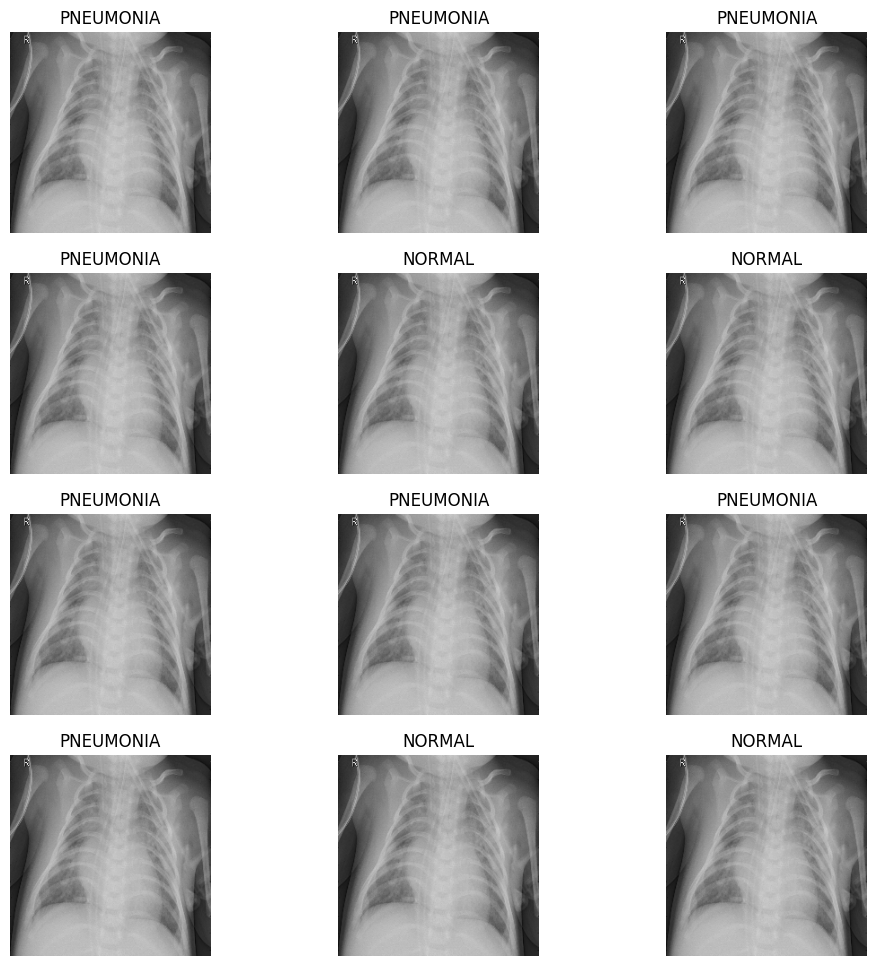

In [45]:
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.imshow(images[1].numpy().astype(int))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [46]:
def preprocess(img, label):
    resized_image = image.resize(img, [224, 224])
    final_image = keras.applications.resnet50.preprocess_input(resized_image * 255)
    return final_image, label

In [47]:
# train_ds = train_ds.map(preprocess).batch(BATCHES).prefetch(1)
# val_ds = val_ds.map(preprocess).batch(BATCHES).prefetch(1)
# test_ds = test_ds.map(preprocess).batch(BATCHES).prefetch(1)

In [48]:
# AUTOTUNE = data.AUTOTUNE

# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [49]:
#data augmentation layer for training

# aug_layer = keras.models.Sequential()

# aug_layer.add(keras.layers.RandomFlip())
# aug_layer.add(keras.layers.RandomRotation(0.2))

In [50]:
#aug_ds = train_ds.map(lambda x, y: (aug_layer(x, training=True), y))

In [51]:
# train_ds = train_ds.concatenate(aug_ds)

In [52]:
# #image preprocessing

# preprocess_layer = keras.models.Sequential()

# preprocess_layer.add(keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE))
# preprocess_layer.add(keras.layers.Rescaling(scale=(1./255) * 255))

In [53]:
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [54]:
#base_model.trainable=False

In [55]:
# model = keras.models.Sequential()

# model.add(preprocess_layer)
# model.add(base_model)
# model.add(keras.layers.GlobalAvgPool2D())
# model.add(keras.layers.Dense(64, activation="relu"))
# model.add(keras.layers.Dense(1, activation="sigmoid"))

In [56]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(2, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [57]:
# adam = keras.optimizers.Adam()
# bin_crossent = keras.losses.BinaryCrossentropy()
# cat_entropy = keras.losses.CategoricalCrossentropy()
# acc = keras.metrics.Accuracy()

# model.compile(optimizer=adam, loss=bin_crossent, metrics=[acc])

In [58]:
for layer in base_model.layers:
    layer.trainable=False

In [59]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [60]:
#model.build(input_shape=INPUT_SHAPE)

In [61]:
# def image_prepocessing(dataset, image_size=IMAGE_SIZE):
#     resized = image.resize(dataset, [image_size, image_size])
#     processed = keras.applications.resnet50.preprocess_input(resized * 255)
#     return processed

In [62]:
# train_ds_preproc = image_prepocessing(train_ds)

In [63]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [64]:
#early_stopping = keras.callbacks.EarlyStopping(patience=3)

In [65]:
history = model.fit(train_ds, epochs=5, verbose=1, validation_data=val_ds)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.8744 - loss: 0.2646 - val_accuracy: 0.8125 - val_loss: 0.2925
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9567 - loss: 0.0939 - val_accuracy: 0.6875 - val_loss: 0.5805
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.9733 - loss: 0.0663 - val_accuracy: 0.6875 - val_loss: 0.6677
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.9768 - loss: 0.0585 - val_accuracy: 0.5625 - val_loss: 0.8142
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.9790 - loss: 0.0535 - val_accuracy: 0.8750 - val_loss: 0.3295


In [66]:
for layer in base_model.layers:
    layer.trainable=True

In [67]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [68]:
#es = keras.callbacks.EarlyStopping(patience=5)
mc = keras.callbacks.ModelCheckpoint("/kaggle/working/my_model.keras", save_best_only=True)

In [69]:
history = model.fit(train_ds, epochs=EPOCHS, batch_size = BATCHES, verbose=1, validation_data=val_ds, callbacks=[mc])

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 345ms/step - accuracy: 0.7365 - loss: 0.9809 - val_accuracy: 0.5000 - val_loss: 7453.7344
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.7873 - loss: 0.3568 - val_accuracy: 0.5000 - val_loss: 0.7506
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 310ms/step - accuracy: 0.8947 - loss: 0.2571 - val_accuracy: 0.5000 - val_loss: 0.8840
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 313ms/step - accuracy: 0.9071 - loss: 0.2287 - val_accuracy: 0.5000 - val_loss: 0.9460
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 311ms/step - accuracy: 0.9198 - loss: 0.2115 - val_accuracy: 0.5000 - val_loss: 3.5253
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 313ms/step - accuracy: 0.9248 - loss: 0.1960 - val_accuracy: 0.5000 - val_loss: 2.3760
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.8514 - loss: 0.3947 - val_accuracy: 0.5000 - val_loss: 102.9115
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 311ms/step - accuracy: 0.8819 - lo

In [70]:
test_loss, test_acc = model.evaluate(test_ds)
test_loss, test_acc

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.6713 - loss: 2.0529


(2.025918483734131, 0.6794871687889099)

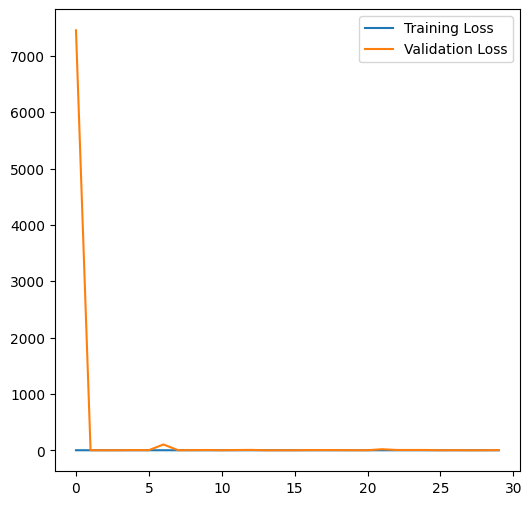

In [71]:
plt.figure(figsize=(6,6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="best")
plt.show()

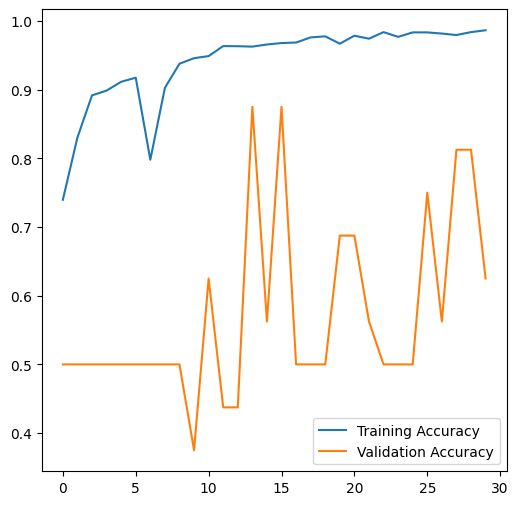

In [72]:
plt.figure(figsize=(6,6))

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
#plt.plot(test_acc, label="Test Accuracy")
plt.legend(loc="best")
plt.show()